# Creating Customer Segments

In this project you, will analyze a dataset containing annual spending amounts for internal structure, to understand the variation in the different types of customers that a wholesale distributor interacts with.

Instructions:

- Run each code block below by pressing **Shift+Enter**, making sure to implement any steps marked with a TODO.
- Answer each question in the space provided by editing the blocks labeled "Answer:".
- When you are done, submit the completed notebook (.ipynb) with all code blocks executed, as well as a .pdf version (File > Download as).

In [1]:
# Import libraries: NumPy, pandas, matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Tell iPython to include plots inline in the notebook
%matplotlib inline

# Read dataset
data = pd.read_csv("wholesale-customers.csv")
print "Dataset has {} rows, {} columns".format(*data.shape)
print data.head()  # print the first 5 rows

Dataset has 440 rows, 6 columns
   Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
0  12669  9656     7561     214              2674          1338
1   7057  9810     9568    1762              3293          1776
2   6353  8808     7684    2405              3516          7844
3  13265  1196     4221    6404               507          1788
4  22615  5410     7198    3915              1777          5185


## Feature Transformation

**1)** In this section you will be using PCA and ICA to start to understand the structure of the data. Before doing any computations, what do you think will show up in your computations? List one or two ideas for what might show up as the first PCA dimensions, or what type of vectors will show up as ICA dimensions.

Answer:

PCA finds the most significant features that show as much variation across the data points. The first PCA dimensions would possibly show which product or group of products that the customers purchase very differently in terms of volume.

ICA tries to untangle the observed features and decompose them to individual factors that, when linearly combined together, would result the observed features. ICA would possibly then identify different groups of customers with similar spending pattern on each product category. For example, there could be a group of customers that purchases a lot milk of products, which then we might say that these customers are operating pastry shops. Another group of customers are spending more on fresh products, which could indicate they are operating restaurants. ICA would show spending pattern of different groups of customers.

### PCA

In [2]:
# TODO: Apply PCA with the same number of dimensions as variables in the dataset
from sklearn.decomposition import PCA
pca = PCA(n_components=data.shape[1])
pca.fit(data)

# Print the components and the amount of variance in the data contained in each dimension
print pca.components_
print pca.explained_variance_ratio_

[[-0.97653685 -0.12118407 -0.06154039 -0.15236462  0.00705417 -0.06810471]
 [-0.11061386  0.51580216  0.76460638 -0.01872345  0.36535076  0.05707921]
 [-0.17855726  0.50988675 -0.27578088  0.71420037 -0.20440987  0.28321747]
 [-0.04187648 -0.64564047  0.37546049  0.64629232  0.14938013 -0.02039579]
 [ 0.015986    0.20323566 -0.1602915   0.22018612  0.20793016 -0.91707659]
 [-0.01576316  0.03349187  0.41093894 -0.01328898 -0.87128428 -0.26541687]]
[ 0.45961362  0.40517227  0.07003008  0.04402344  0.01502212  0.00613848]


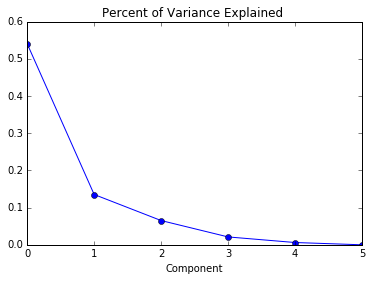

In [3]:
def plot_variance(variance_ratio):
    xx = np.arange(variance_ratio.shape[0])
    plt.plot(xx, 1 - np.cumsum(variance_ratio), '-o')
    plt.xlabel('Component')
    plt.title('Percent of Variance Explained ')
    plt.show()

plot_variance(pca.explained_variance_ratio_)

**2)** How quickly does the variance drop off by dimension? If you were to use PCA on this dataset, how many dimensions would you choose for your analysis? Why?

Answer: 

The explained variance ratio plummeted on the 3rd principal component.

I’ll use 2 dimensions for my analysis. The first 2 components have significantly higher variance compared to the other lower 3 components. The lower 3 components have very low variance, which means if not included in the analysis, there are only minimal information loss when reconstructed back to the original space. Also, 2 dimensions is convenient for visualization purposes.

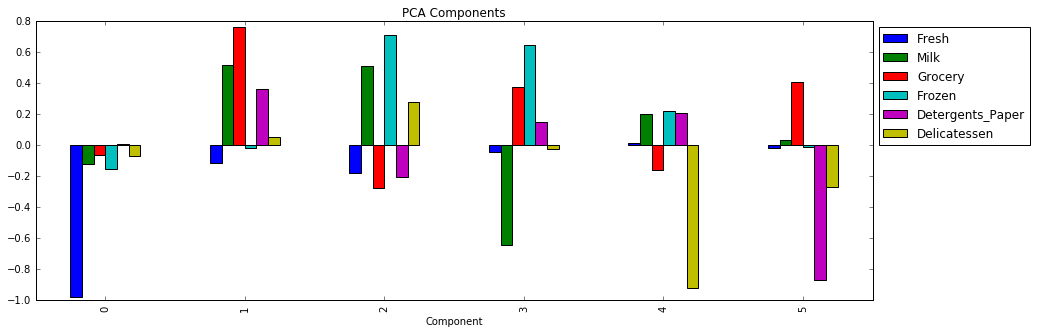

In [4]:
def visualize_comp(comp, features=None, title=None):
    labels = features or ["Feature {}".format(i) for i in range(F)]
    df = pd.DataFrame(comp, columns=labels)
    df.index.name = "Component"
    ag = df.plot.bar(figsize=(15, 5), title=title or "Components")
    ag.legend(bbox_to_anchor=(1., 1.), loc="upper left")

visualize_comp(pca.components_, features=list(data.columns), title="PCA Components")

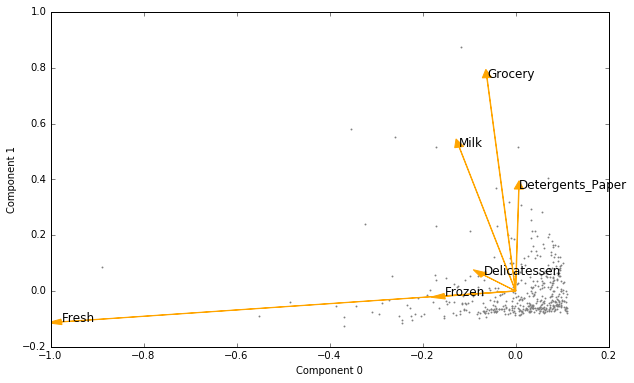

In [5]:
from sklearn.preprocessing import MinMaxScaler

def biplot(t_data, components, labels):
    scaler = MinMaxScaler().fit(t_data)
    means = scaler.transform(t_data.mean(axis=0).reshape(1, -1))
    t_data = scaler.transform(t_data) -  means

    plt.figure(figsize=(10, 6))
    plt.scatter(t_data[:, 0], t_data[:, 1], s=0.8, color='gray')
    
    for label, (xc, yc) in zip(labels, np.c_[components[0], components[1]]):
        plt.arrow(0, 0, xc, yc, width=0.001, fc='orange', ec='orange')
        plt.annotate(label, (xc, yc), size=12, color='k')
    
    plt.xlabel('Component 0')
    plt.ylabel('Component 1')
    plt.show()

# Plot first 2 components
biplot(pca.transform(data)[:, :2], components=pca.components_[:2], labels=data.columns)

**3)** What do the dimensions seem to represent? How can you use this information?

Answer: 

Each component seems to represent broader categories of products. Component 1 shows milk, grocery, and detergents and paper products go along together and have strong relationship. Component 0 shows fresh products are an entirely different category by itself.

The first component is strongly influenced by fresh product, and some milk and frozen products. This indicates that most variation of customers is in terms of purchasing fresh products.

The second component is influenced by grocery, milk, and detergent and paper products.

By grouping together categories with strong relationship, the dimensionality of the dataset is reduced while minimizing the information loss on the annual spending on the categories.

### ICA

In [6]:
# TODO: Fit an ICA model to the data
# Note: Adjust the data to have center at the origin first!
from sklearn.decomposition import FastICA
ica = FastICA()
centered_data = data - data.mean()
ica.fit(centered_data)

# Print the independent components
print ica.components_

[[  2.68171298e-07  -2.69272125e-06  -1.13090210e-05   1.50188458e-06
    2.79174648e-05   5.73484760e-06]
 [  3.87451055e-07   2.17361274e-07   5.96917225e-07   5.18359193e-07
   -5.26960901e-07  -1.80872061e-05]
 [ -3.97878936e-06   8.97757348e-07   7.62884532e-07   6.64047278e-07
   -2.38450379e-06   9.57440753e-07]
 [  1.67907272e-07   9.76409373e-06  -6.02024375e-06  -3.22604373e-07
    3.97861153e-06  -5.95288823e-06]
 [  8.63431587e-07   1.46968660e-07  -7.79555060e-07  -1.11475521e-05
    5.41729333e-07   5.95388208e-06]
 [ -1.92590434e-07   1.77565061e-06  -7.49329971e-06  -2.69252866e-07
    3.25639847e-06   1.91737846e-06]]


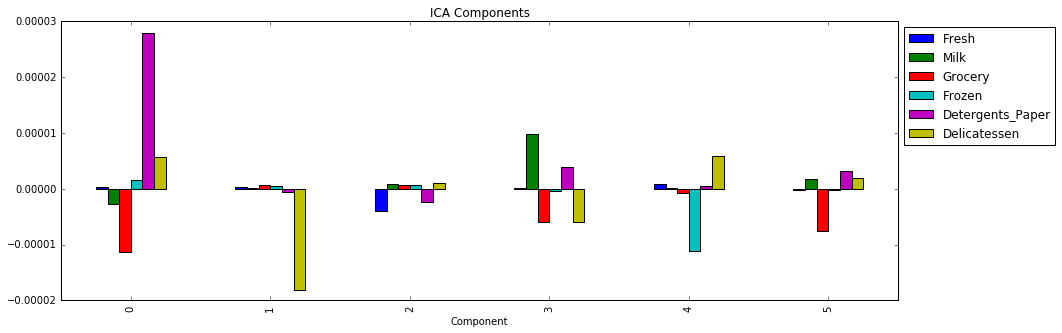

In [7]:
visualize_comp(ica.components_, features=list(data.columns), title="ICA Components")

**4)** For each vector in the ICA decomposition, write a sentence or two explaining what sort of object or property it corresponds to. What could these components be used for?

Answer:

**Component 0:** Corresponds to grocery stores or hotels. Customers with high demand for grocery products, but not paper products could represents grocery store customers, while the opposite would be true for hotel customers.

**Component 1:** Corresponds to deli counters. Delicatessen is the only dominant feature, which strongly suggests that these customers operate deli counters.

**Component 2:** Corresponds to restaurants. It is dominated by fresh products and some detergent and paper products. Restaurants usually have suppliers for fresh produce for their menus. The need for kitchen supplies would explain their demand for detergent and paper products.

**Component 3:** Corresponds to cafés. A good portion of milk products, and detergent and paper products, this customer may be operating cafés.

**Component 4:** Corresponds to fast food shops. It is dominated by frozen products. Fast food shops normally have frozen supplies for their products.

**Component 5:** Corresponds to convenience/retail stores. It is dominated by grocery products, which indicates that the customer is most likely reselling those products.

These components could be use for identifying different types of customers. By identifying the type of customers, we can understand their shopping habits. Business decisions or sales/promotions can be made targeted to specific customer groups.


## Clustering

In this section you will choose either K Means clustering or Gaussian Mixed Models clustering, which implements expectation-maximization. Then you will sample elements from the clusters to understand their significance.

### Choose a Cluster Type

**5)** What are the advantages of using K Means clustering or Gaussian Mixture Models?

Answer: 

K Means uses hard assignments, while GMM uses soft assignments. In K Means, data points are assigned to the closest centroid; while GMM assigns probabilities of which cluster it most likely belong. GMM would therefore make a better judgment for data points that are on the borderline between centroids; or make better judgment for dataset where there are no obvious natural grouping or clear boundaries between clusters.


K Means generate Voronoi-shaped clusters that only extend up to half way between other centroids, or extend indefinitely on other edge if there is no other centroid on that side. While GMM gives more structural information on the cluster and can show wide the cluster can reach.

K Means would generally run faster than GMM since GMM requires more computations.

Our dataset doesn’t appear to have an obvious natural obvious grouping.  Potential clusters will have no sharp decision boundaries, and can easily overlap. A good approach would be to find clusters in terms of density, and each data point will have probabilities to which cluster it most likely belongs. GMM would be appropriate for this case.

**6)** Below is some starter code to help you visualize some cluster data. The visualization is based on [this demo](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html) from the sklearn documentation.

In [8]:
# Import clustering modules
from sklearn.cluster import KMeans
from sklearn.mixture import GMM

In [9]:
# TODO: First we reduce the data to two dimensions using PCA to capture variation
reduce_fit = PCA(n_components=2).fit(data)
reduced_data = reduce_fit.transform(data)
print reduced_data[:10]  # print upto 10 elements

[[  -650.02212207   1585.51909007]
 [  4426.80497937   4042.45150884]
 [  4841.9987068    2578.762176  ]
 [  -990.34643689  -6279.80599663]
 [-10657.99873116  -2159.72581518]
 [  2765.96159271   -959.87072713]
 [   715.55089221  -2013.00226567]
 [  4474.58366697   1429.49697204]
 [  6712.09539718  -2205.90915598]
 [  4823.63435407  13480.55920489]]


Best score: 18333.8783064
Covariance model: diag
Components: 8
GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=8, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)


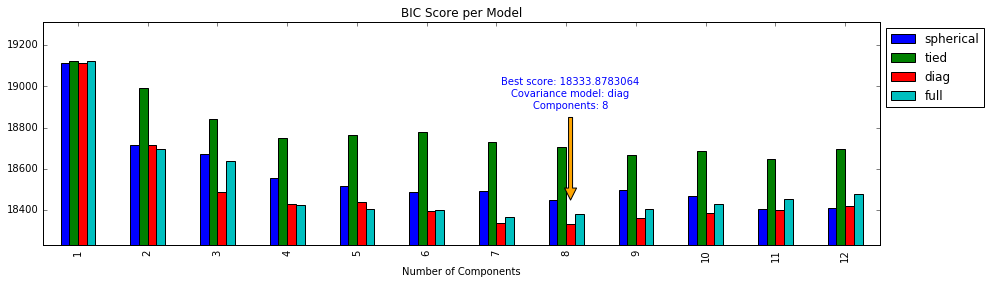

In [10]:
# TODO: Implement your clustering algorithm here, and fit it to the reduced data for visualization
# The visualizer below assumes your clustering object is named 'clusters'

def grid_search_gmm(X, max_n=6):    
    cv_types = ['spherical', 'tied', 'diag', 'full']
    n_counts = [i + 1 for i in range(max_n)]
    
    best_gmm = {'gmm': None, 'score': np.inf}
    def get_bic(c, i):
        gmm = GMM(n_components=i, covariance_type=c).fit(X)
        score = gmm.bic(X)
        if score < best_gmm['score']:
            best_gmm['gmm'] = gmm
            best_gmm['score'] = score
        return score
    
    # Get BIC scores across all covariance types, up to max_n components each
    bics  = np.array([[get_bic(c, i) for c in cv_types] for i in n_counts])

    # Visualize scores
    df = pd.DataFrame(bics, columns=cv_types, index=n_counts)
    df.index.name = "Number of Components"
    ag = df.plot.bar(figsize=(15, 4), title="BIC Score per Model",
                    ylim=(bics.min() * 1.01 - .015 * bics.max(),  bics.max() * 1.01))
    ag.legend(bbox_to_anchor=(1., 1.), loc="upper left")
    
    # Annotate best BIC score
    text = "Best score: {0}\nCovariance model: {gmm.covariance_type}\nComponents: {gmm.n_components}"\
            .format(best_gmm['score'], gmm=best_gmm['gmm'])
    c_idx = cv_types.index(best_gmm['gmm'].covariance_type)
    r_idx = n_counts.index(best_gmm['gmm'].n_components)
    ag.annotate(text, xy=(r_idx + c_idx * 0.125 - 0.1875, best_gmm['score'] * 1.005), 
                xytext=(r_idx + c_idx * 0.125 - 0.1875, best_gmm['score'] * 1.03),
                ha="center", va="bottom",
                arrowprops=dict(facecolor='orange', shrink=0.05), 
                size=10, color='b')
    print text
    
    return best_gmm['gmm']

clusters = grid_search_gmm(reduced_data, max_n=12)
print clusters

In [11]:
# Plot the decision boundary by building a mesh grid to populate a graph.
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
hx = (x_max-x_min)/1000.
hy = (y_max-y_min)/1000.
xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

# Obtain labels for each point in mesh. Use last trained model.
Z = clusters.predict(np.c_[xx.ravel(), yy.ravel()])

In [12]:
# TODO: Find the centroids for KMeans or the cluster means for GMM 

centroids = clusters.means_
print centroids

[[   7549.90079159   -5249.1086203 ]
 [   2776.94679273   15018.18800395]
 [ -26065.24600297   -8381.4913312 ]
 [  -5476.32462616    -990.10553452]
 [   9409.05698006    5444.18729167]
 [ -19710.9394465    45610.15223872]
 [-103863.42532004    9910.34962857]
 [    509.8119812    -7655.93555606]]


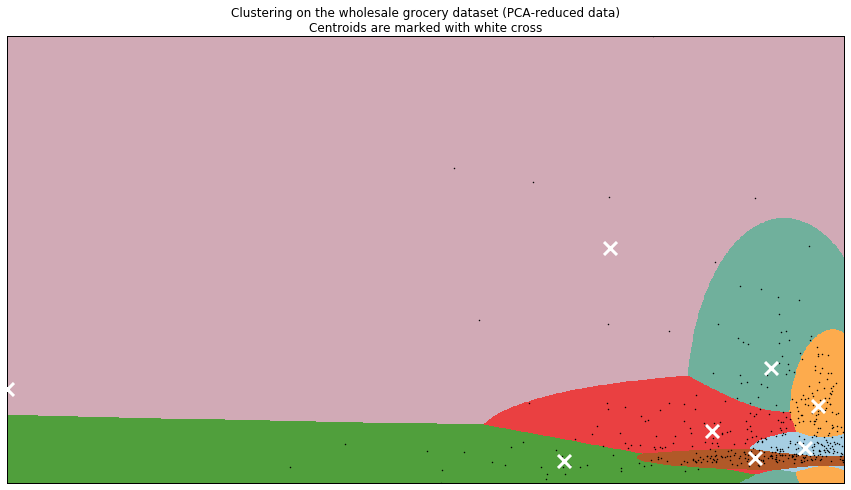

In [13]:
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(15,8))
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

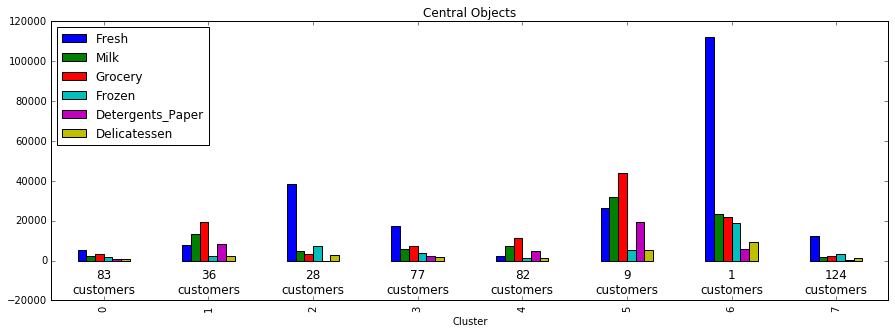

In [14]:
def plot_cenral_objects(central_objects, counts, features):
    
    # Visualize scores
    df = pd.DataFrame(central_objects, columns=features)
    df.index.name = "Cluster"
    ag = df.plot.bar(figsize=(15, 5), title="Central Objects")
    ag.legend(loc="upper left")
    
    # Show number of customers in each cluster
    for i, count in enumerate(counts):
        ag.annotate("{}\ncustomers".format(count), 
                    xy=(i, -4000), ha="center", va="top", 
                    size=12, color='k')
    
plot_cenral_objects(reduce_fit.inverse_transform(centroids),
               np.bincount(clusters.predict(reduced_data)), 
               list(data.columns))

**7)** What are the central objects in each cluster? Describe them as customers.

Answer: 

There appears to be several clusters that have similar purchasing pattern, but with varying volumes.

Clusters 1, 4, and 5 spend mostly on groceries, milk, and detergent and paper products with similar ratio between the categories. They vary in overall volume, which can be classified as high, medium, low volume grocery products customers; cluster 5 being high, cluster 1 being medium, and cluster 4 being low. It can also be noted that there is a low number of customers in the high volume cluster.

There is only 1 customer in cluster 6, and have a very significant value on fresh products. This could be an encoding error, or there is actually 1 special customer who loves fresh products a little too much. Either way, this data point is a definite outlier.

Clusters 2 and 7 are significantly dominated by fresh products, while there are very low amount of other products. They can be categorized as high (cluster 2) and low (cluster 7) volume fresh products customers. Most customers fall on low volume fresh product category, and there are a significantly lower number of customers in the high volume category.

Clusters 0 and 3 have similar purchasing pattern. They are dominated by fresh products as well, however they also have a good portion of other product categories. They can be classified as midium (cluster 3) and low (cluster 0) volume general customers. There is an equal distribution of customers between these high and low categories.

To summarize:

|Customer Type   |High Volume|Medium Volume|Low Volume|
|----------------|:---------:|:-----------:|:--------:|
|Grocery Shoppers|9          |36           |82        |
|Fresh Shoppers  |28         |N/A          |124       |
|General Shoppers|N/A        |77           |83        |

### Conclusions

** 8)** Which of these techniques did you feel gave you the most insight into the data?

Answer:

All three techniques gave useful insights into the data, depending on what we want to see. PCA showed the relationship of product demands between product categories. ICA showed different types of customers. Clustering showed low and high volume customers.

Clustering uncovered the most hidden information in the dataset. It showed groups of customers with similar shopping pattern based on the categories of products, and the same time showed groups with similar volume of spending for each pattern. It also showed the distribution of customers in each category, and it uncovered an outlier. 

**9)** How would you use that technique to help the company design new experiments?

Answer: 

Using a combination of these techniques, we can compartmentalize customers into different groups. New experiments can be designed to target specific groups and see which groups yield positive or negative results. 

For example, we want to test evening delivery. Our hypothesis is evening delivery will increase customer satisfaction. In clustering, we have identified 77 customers as mid-volume general shoppers. Fifty percent of these customer group can but put on the new delivery method (Group A), while the remaining 50% stays on the current (Group B). If for example there is more satisfied customer in Group A, then we can conclude that evening delivery increases customer satisfaction for high-volume general customers. If there are equal satisfied customers between the groups, then evening delivery has no effect. If there are more satisfied customers in Group B, then evening delivery has negative effect.

This test result may only be true for mid-volume general shoppers, and not for other customer segments. The same test can be conducted again, but this time targeted to other customer groups. Depending on conversion rate on each group, we selectively apply the new evening delivery only to those customer groups that responded very well on the test.

**10)** How would you use that data to help you predict future customer needs?

Answer: 

We can use some of these techniques in conjunction with supervised learning techniques, which helps us predict future customer needs.

For example, suppose that we have collected more information overtime, and our dataset gets more variables or features; making the size of our dataset very large. It might be helpful to use PCA and use only the top components, and discarding lower components with smaller variance ratio. This would cut down the size of the dataset with minimal information loss. The reduced dataset can then be fed as input to supervised learning which would then be more efficient given the smaller size of the dataset.